In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
def pd_csv_to_h5py(directory, file):
    """ Loads photodiode data from csv file and saves to h5py file.

    Parameters
    ----------
    directory: full path to vision folder
    file: csv file

    Returns
    -------
    Nothing. """

    print('loading raw photodiode data... ',end='')
    #load raw data from csv
    load_file = os.path.join(directory, file)
    temp = np.genfromtxt(load_file, delimiter=',',skip_header=1)
    t = temp[:,0]
    ft_triggers = temp[:,1]
    pd1 = temp[:,2]
    pd2 = temp[:,3]
    print('done')

    #save as h5py file
    print('saving photodiode data as h5py file...',end='')
    save_file = os.path.join(directory, 'photodiode.h5')
    with h5py.File(save_file, 'w') as hf:
        hf.create_dataset('time',  data=t)
        hf.create_dataset('ft_triggers',  data=ft_triggers)
        hf.create_dataset('pd1',  data=pd1)
        hf.create_dataset('pd2',  data=pd2)
    print('done')
    
def load_h5py_pd_data(directory):
    """ Loads photodiode data from h5py file.

    Parameters
    ----------
    directory: full path to vision folder

    Returns
    -------
    t: 1D numpy array, times of photodiode measurement (in ms)
    pd1: 1D numpy array, photodiode 1 measurements
    pd2: 1D numpy array, photodiode 1 measurements """

    print('loading photodiode data... ',end='')
    #load from h5py file
    load_file = os.path.join(directory, 'photodiode.h5')
    with h5py.File(load_file, 'r') as hf:
        t = hf['time'][:]
        ft_triggers = hf['ft_triggers'][:]
        pd1 = hf['pd1'][:]
        pd2 = hf['pd2'][:]
    print('done')
    return t, ft_triggers, pd1, pd2

def load_photodiode(vision_path):
    """ Tries to load photodiode data from h5py file, and if it doesn't exist loads from csv file.

    Parameters
    ----------
    vision_path: full path to vision folder

    Returns
    -------
    t: 1D numpy array, times of photodiode measurement (in ms)
    pd1: 1D numpy array, photodiode 1 measurements
    pd2: 1D numpy array, photodiode 1 measurements """

    # Try to load from h5py file
    try:
        t, ft_triggers, pd1, pd2 = load_h5py_pd_data(vision_path)
        
    # First convert from csv to h5py, then load h5py
    except:
        pd_csv_to_h5py(vision_path,'photodiode.csv')
        t, ft_triggers, pd1, pd2 = load_h5py_pd_data(vision_path)
    return t, ft_triggers, pd1, pd2


def get_pd_thresh(pd):
    """ Finds threshold for ON vs OFF photodiode.

    Parameters
    ----------
    pd: photodiode values across time

    Returns
    -------
    threshold: int, threshold of ON vs OFF for photodiode

    """
    _, bins, _ = plt.hist(pd,bins=5)
    plt.close()
    threshold = (bins[0] + bins[-1]) / 2
    return threshold

def parse_stim_starts_photodiode(pd, stimuli):
    """ Finds all times in the photodiode recording when a stimulus began.

    Parameters
    ----------
    pd: photodiode values across time
    stimuli: all stimuli presented. Used for checking length of stimuli starts to make sure all stimuli were found

    Returns
    -------
    stimuli_starts: list of start times of all stimuli in order (in ms).

    """
    # Get threshold for on/off
    threshold = get_pd_thresh(pd)

    # Find timepoints when the light is off (and convert to ms)
    pd_sampling_to_ms_conversion = 10
    pd_off = np.where(pd<threshold)[0]/pd_sampling_to_ms_conversion

    # Find timepoints of rising edges
    min_gap = 1 # Lets give a 1 ms window for defining edges
    pd_on_edges = pd_off[np.where(np.diff(pd_off)>min_gap)[0]]

    # Remove any very early on edges cause by projector still getting ready etc.
    remove_on_before = 5*1000 # Currently a 30 sec minimum
    pd_on_edges = [x for x in pd_on_edges if x > remove_on_before]
    
    # Add on edge at 0
    pd_on_edges = np.insert(pd_on_edges,0,0)

    # Find on_edges that correspond to stimuli presentation
    min_gap = 100 # Edges greater than 100ms apart are counted as stimuli starts
    stimuli_starts = pd_on_edges[np.where(np.diff(pd_on_edges)>min_gap)[0]+1]
    
    # Make sure we have successfully found all stimuli
#     if len(stimuli_starts) == len(stimuli):
#         print('Successfully parsed all stimuli from photodiode output.')
#     else:
#         print(len(stimuli_starts))
#         print(len(stimuli))
#         raise Exception('Failed to successfully parse stimuli from photodiode output')
    return stimuli_starts #in ms

In [ ]:
stimuli = 'a'
stimuli_starts = parse_stim_starts_photodiode(pd1, stimuli)

In [3]:
vision_path = '/oak/stanford/groups/trc/data/Brezovec/20220218/'
t, ft_triggers, pd1, pd2 = load_photodiode(vision_path)

loading photodiode data... done


In [9]:
len(ft_triggers)

18000000

In [14]:
ft_triggers[0], ft_triggers[-1]

(3.3026123046875, 0.0030517578125)

(17999000, 18000000)

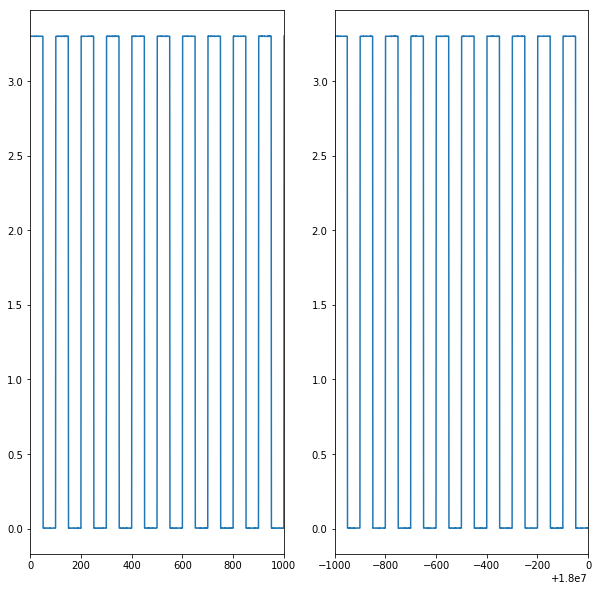

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.plot(ft_triggers)
plt.xlim(0,1000)

plt.subplot(122)
plt.plot(ft_triggers)
plt.xlim(18000000-1000,18000000)

In [8]:
ft_triggers[0]

3.3026123046875

In [59]:
pd = pd2

In [94]:
threshold = get_pd_thresh(pd2)

In [99]:
pd_sampling_to_ms_conversion = 10
pd_off = np.where(pd2<threshold)[0]/pd_sampling_to_ms_conversion

In [100]:
min_gap = 1 # Lets give a 1 ms window for defining edges
pd_on_edges = pd_off[np.where(np.diff(pd_off)>min_gap)[0]]

In [107]:
np.diff([0,1,0])

array([ 1, -1])

In [108]:
pd_on_edges

array([   3061.7,    3078.4,    3095.1, ..., 1797022.7, 1797039.4,
       1797056. ])

In [109]:
np.diff(pd_on_edges) 

array([16.7, 16.7, 16.6, ..., 16.7, 16.7, 16.6])

In [105]:
len(pd_on_edges)

50857

In [85]:
test = pd_on_edges[np.where(np.diff(pd_on_edges)>remove_flips)[0]]

In [101]:
pd_on_edges

array([   3061.7,    3078.4,    3095.1, ..., 1797022.7, 1797039.4,
       1797056. ])

In [106]:
len(test)
#should be 318 stim

311

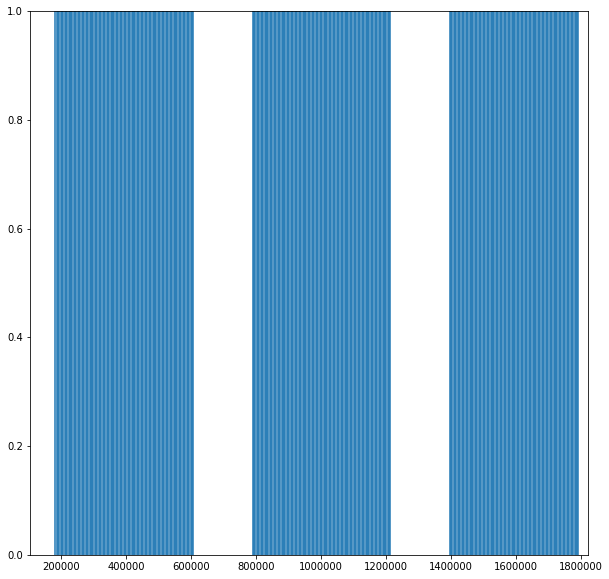

In [161]:
plt.figure(figsize=(10,10))
for i in range(len(test)):
    plt.axvline(test[i])
#plt.xlim(400000,500000)

In [163]:
len(np.where(test<700000)[0])

106

In [171]:
len(np.where(np.logical_and(test>700000,test<1300000))[0])

106

In [172]:
len(np.where(test>1300000)[0])

99

In [180]:
np.mean([i for i in np.diff(test) if i<5000])

4038.7282467532464

In [181]:
16*2

32

Text(0, 0.5, 'number of presentations')

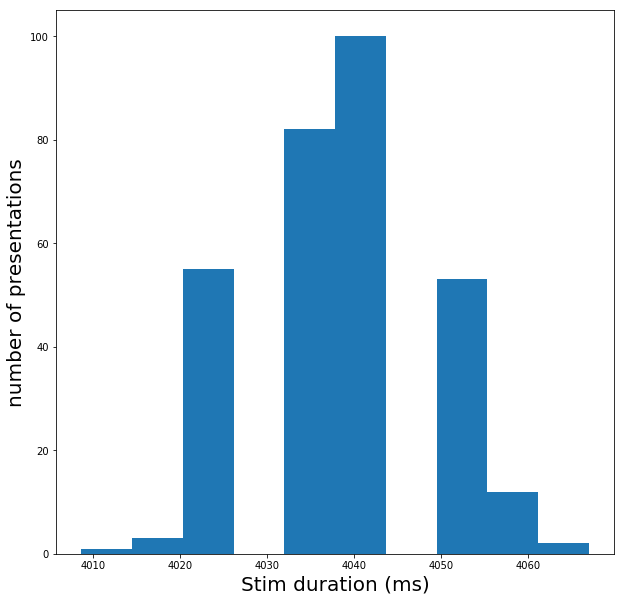

In [179]:
plt.figure(figsize=(10,10))
plt.hist([i for i in np.diff(test) if i<5000]);
plt.xlabel('Stim duration (ms)',fontsize=20)
plt.ylabel('number of presentations',fontsize=20)

In [93]:
np.where(np.diff(pd_on_edges)>remove_flips)[0]

array([10695, 10756, 10816, 10876, 10936, 10997, 11057, 11116, 11176,
       11236, 11296, 11356, 11416, 11476, 11536, 11596, 11657, 11717,
       11777, 11836, 11896, 11956, 12017, 12077, 12138, 12198, 12259,
       12319, 12379, 12439, 12499, 12559, 12619, 12680, 12740, 12800,
       12860, 12921, 12981, 13041, 13102, 13162, 13222, 13283, 13343,
       13404, 13465, 13525, 13585, 13645, 13706, 13766, 13827, 13887,
       13946, 14007, 14067, 14127, 14187, 14247, 14307, 14367, 14427,
       14487, 14548, 14608, 14669, 14730, 14790, 14850, 14910, 14970,
       15030, 15090, 15143, 15203, 15263, 15324, 15384, 15444, 15505,
       15565, 15625, 15685, 15745, 15805, 15865, 15925, 15985, 16045,
       16105, 16166, 16227, 16287, 16347, 16407, 16467, 16527, 16588,
       16648, 16708, 16768, 16829, 16889, 16949, 17010, 27808, 27868,
       27928, 27988, 28048, 28108, 28168, 28228, 28289, 28349, 28410,
       28470, 28530, 28590, 28650, 28710, 28770, 28830, 28890, 28950,
       29010, 29070,

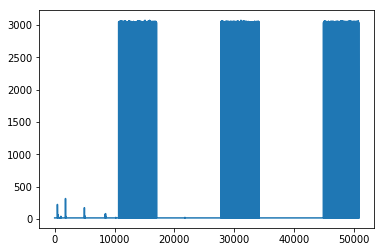

In [82]:
# These on edges include frame flips but we want just the starts of stimuli
remove_flips = 500 # this is 500ms
plt.plot(np.diff(pd_on_edges))

In [77]:
pd_on_edges[0], pd_on_edges[1]

(3061.7, 3078.4)

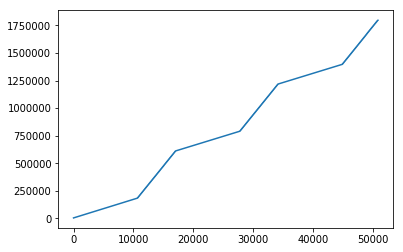

In [63]:
plt.plot(pd_on_edges)

In [53]:
ft_triggers.shape

(18000000,)

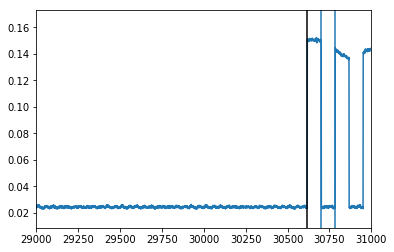

In [103]:
plt.plot(pd2)
plt.xlim(30000-1000,30000+1000)
plt.axvline(pd_on_edges[0]*10,color='k')
plt.axvline(30617+83)
plt.axvline(30784)

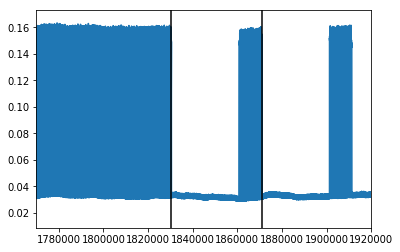

In [114]:
plt.plot(pd2)
start = ((3 + 60*3) * 10000)
end = start + (5*10000)
plt.xlim(start-10000*6,end+10000*4)

plt.axvline(183036.2*10,color='k')
plt.axvline(187086.5*10,color='k')


In [182]:
one_stim = pd2[1800000:1900000]

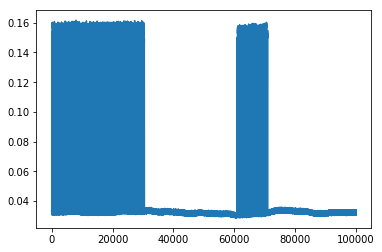

In [183]:
plt.plot(one_stim)

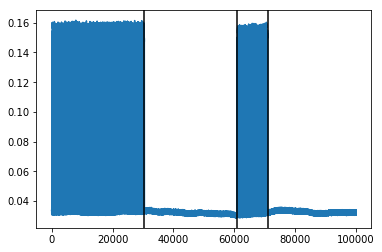

In [214]:
plt.plot(one_stim)
#plt.xlim(30400,30475)
#plt.xlim(60850,60900)
#plt.xlim(70900,71000)
plt.axvline(30445,color='k')
plt.axvline(60864,color='k')
plt.axvline(70950,color='k')

In [ ]:
# grey period started at 30445 (or 30446)
# stim starts at 60864 (or 60865)
# stim ends at 70950

In [205]:
60865-30445

30420

In [213]:
70950-60865

10085

In [215]:
1/120

0.008333333333333333

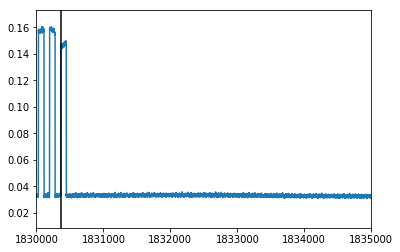

In [132]:
# this is the first trigger from above
plt.plot(pd2)
start = ((60*3+3) * 10000)+10000
end = start + (5000)-10000
plt.xlim(start-10000,end)

plt.axvline(183036.2*10,color='k')
plt.axvline(187086.5*10,color='k')


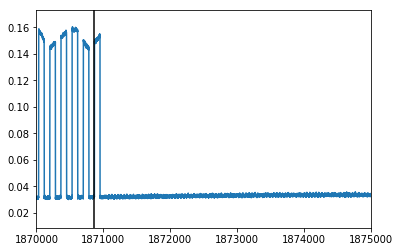

In [133]:
# this is the 2nd trigger from above
plt.plot(pd2)
start = ((60*3+3+4) * 10000)+10000
end = start + (5000)-10000
plt.xlim(start-10000,end)

plt.axvline(183036.2*10,color='k')
plt.axvline(187086.5*10,color='k')


In [115]:
187086.5-183036.2

4050.2999999999884

In [73]:
# 120 hz display is 
1/120
#0.00833s


0.008333333333333333

In [68]:
#sampling rate is 
# aquired 18000000 samples over 30min
18000000/30/60
#that is 10000 samples a second
#or one sample every 0.1ms
# so 3 sec would have 30000 samples

10000.0

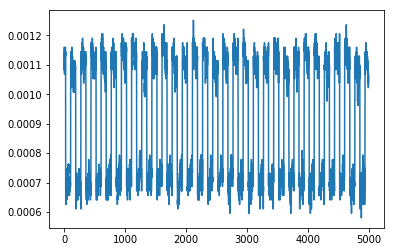

In [39]:
plt.plot(temp[40000:45000,2])

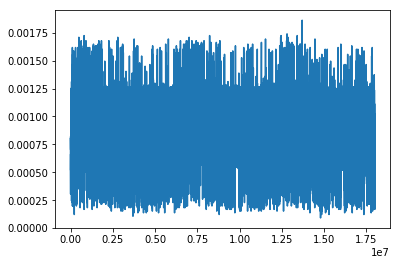

In [40]:
plt.plot(temp[:,2])

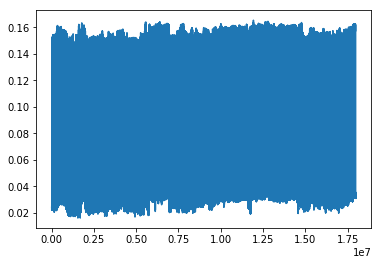

In [41]:
plt.plot(temp[:,3])

In [233]:
# frame_monitor_channels, time_vector, sample_rate = self.getPhotodiodeData()
# run_parameters = self.getRunParameters()
# epoch_parameters = self.getEpochParameters()

threshold=0.8,
command_frame_rate=120

frame_monitor = pd2
time_vector = t
sample_rate = 10000


#if len(frame_monitor_channels.shape) == 1:
#    frame_monitor_channels = frame_monitor_channels[np.newaxis, :]

minimum_epoch_separation = 0.9 * (3 + 0) * sample_rate


#frame_monitor = frame_monitor_channels[ch, :]

# Low-pass filter frame_monitor trace
#     b, a = scipy.signal.butter(4, 10*command_frame_rate, btype='low', fs=sample_rate)
#     frame_monitor = signal.filtfilt(b, a, frame_monitor)

# shift & normalize so frame monitor trace lives on [0 1]
frame_monitor = frame_monitor - np.min(frame_monitor)
frame_monitor = frame_monitor / np.max(frame_monitor)

# find frame flip times
V_orig = frame_monitor[0:-2]
V_shift = frame_monitor[1:-1]
ups = np.where(np.logical_and(V_orig < threshold, V_shift >= threshold))[0] + 1
downs = np.where(np.logical_and(V_orig >= threshold, V_shift < threshold))[0] + 1
frame_times = np.sort(np.append(ups, downs))

# Use frame flip times to find stimulus start times
stimulus_start_frames = np.append(0, np.where(np.diff(frame_times) > minimum_epoch_separation)[0] + 1)
stimulus_end_frames = np.append(np.where(np.diff(frame_times) > minimum_epoch_separation)[0], len(frame_times)-1)
stimulus_start_times = frame_times[stimulus_start_frames] / sample_rate  # datapoints -> sec
stimulus_end_times = frame_times[stimulus_end_frames] / sample_rate  # datapoints -> sec

stim_durations = stimulus_end_times - stimulus_start_times # sec

(0, 100000)

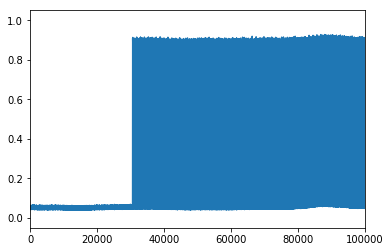

In [232]:
plt.plot(frame_monitor)
plt.xlim(0,100000)

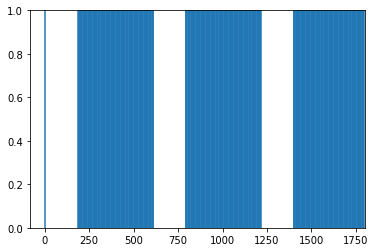

In [234]:
for i in range(len(stimulus_start_times)):
    plt.axvline(stimulus_start_times[i])

In [237]:
len(stimulus_start_times)

312

In [236]:
np.diff(stimulus_start_times)

array([183.0247,   4.0421,   4.042 ,   4.042 ,   4.0337,   4.042 ,
         4.0504,   4.0254,   4.042 ,   4.0352,   4.0405,   4.0421,
         4.042 ,   4.0337,   4.042 ,   4.0337,   4.042 ,   4.0421,
         4.0503,   4.0337,   4.0337,   4.0337,   4.042 ,   4.0338,
         4.042 ,   4.0337,   4.0503,   4.0337,   4.0504,   4.0253,
         4.0504,   4.042 ,   4.0337,   4.0421,   4.042 ,   4.0337,
         4.0337,   4.0503,   4.0337,   4.0337,   4.0421,   4.042 ,
         4.0253,   4.0504,   4.0254,   4.042 ,   4.0504,   4.0253,
         4.0337,   4.0337,   4.042 ,   4.0421,   4.042 ,   4.0504,
         4.0253,   4.0504,   4.042 ,   4.0504,   4.042 ,   4.0337,
         4.042 ,   4.0421,   4.042 ,   4.0337,   4.042 ,   4.0337,
         4.0421,   4.042 ,   4.0337,   4.042 ,   4.0337,   4.0337,
         4.042 ,   4.0587,   4.0421,   4.0336,   4.0338,   4.0503,
         4.0337,   4.0337,   4.042 ,   4.0421,   4.042 ,   4.0337,
         4.0503,   4.0337,   4.0587,   4.0421,   4.0337,   4.0

In [220]:
minimum_epoch_separation

9000.0

In [226]:
stim_durations

array([2.855730e+01, 1.235100e+01, 1.020427e+02, 1.442180e+01,
       7.370000e-01, 4.430800e+00, 9.918000e-01, 9.751000e-01,
       9.917000e-01, 9.918000e-01, 9.918000e-01, 5.033800e+00,
       9.917000e-01, 5.033800e+00, 1.008400e+00, 9.918000e-01,
       9.917000e-01, 9.059200e+00, 1.008400e+00, 9.918000e-01,
       1.311790e+01, 9.067500e+00, 9.918000e-01, 9.918000e-01,
       1.008400e+00, 5.033700e+00, 9.917000e-01, 1.008400e+00,
       1.341500e+01, 1.073100e+00, 1.008500e+00, 5.033800e+00,
       9.067500e+00, 9.918000e-01, 4.545410e+01, 5.033800e+00,
       1.008400e+00, 5.042100e+00, 1.008500e+00, 9.917000e-01,
       9.917000e-01, 9.918000e-01, 9.918000e-01, 9.918000e-01,
       9.918000e-01, 9.834000e-01, 9.918000e-01, 9.918000e-01,
       1.008500e+00, 9.918000e-01, 9.918000e-01, 1.008400e+00,
       9.918000e-01, 9.917000e-01, 1.000100e+00, 9.917000e-01,
       9.084200e+00, 1.582680e+01, 5.242000e+00, 9.918000e-01,
       2.705000e+00, 6.690000e-02, 1.500000e-01, 1.7975

In [218]:
downs

array([   30702,    30868,    31035, ..., 17578932, 17579014, 17581600])

In [216]:
frame_times

array([   30618,    30702,    30785, ..., 17579015, 17581600, 17581601])

In [155]:
len(stim_durations)

200

In [153]:
len(pd2)

18000000